# Aprendizaje no supervisado

## 1. Librerias y Datos

In [1]:
import pandas as pd
import numpy as np
import io
import warnings
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
warnings.filterwarnings('ignore')

# Useful functions
from src.utils import load_examples, plot_scatter, plot_silhouette

from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('data.csv')
data['stays_nights']=data.stays_in_weekend_nights+data.stays_in_week_nights
data=data.drop(['stays_in_weekend_nights','stays_in_week_nights'],axis=1)
data.head()

,Unnamed: 0,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,...,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party,stays_nights
0,0,0.0,13.077658,2015.0,27.0,1.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1,1,1.0,7.389493,2015.0,27.0,1.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
2,2,0.0,7.755577,2015.0,27.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
3,3,0.0,13.077658,2015.0,27.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
4,4,1.0,7.389493,2015.0,27.0,1.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0


## 2. K-means

Lo vamos a separar en dos partes:
1. Primero vamos a usar como objetivo la variabla is_canceled, por lo que vamos a intentar clasificar nuestros datos en dos clusters y ver el resultado.

2. Despúes vamos a ver cual es el número más óptimo de clusters utilizando como objetivo la variable stays_nights, para entonces ver si tiene sentido separar esa variable en varias subclases en función del número de clusters 

### Variable Objetivo: is_canceled

In [3]:
X = data.drop(['is_canceled', 'Unnamed: 0'], axis=1).values
Y = data.is_canceled

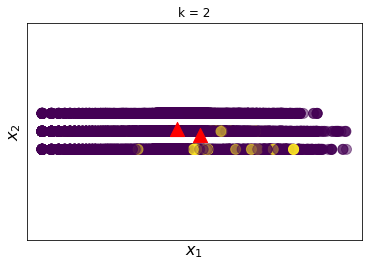

In [4]:
# build the clustering model
k = 2
kmeans = KMeans(n_clusters = k)
kmeans.fit(X)

# Centroids 
centroids = kmeans.cluster_centers_

# Labels
cluster_labels = kmeans.labels_

# do the plotting
plot_scatter(X,'k = ' + str(k), cluster_labels, centroids)
plt.show()

In [5]:
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
Y

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
29995    0.0
29996    0.0
29997    0.0
29998    1.0
29999    0.0
Name: is_canceled, Length: 30000, dtype: float64

In [7]:
k = 2
kmeans = KMeans(n_clusters=k).fit(X)
kmeans.inertia_

12556176.141185038

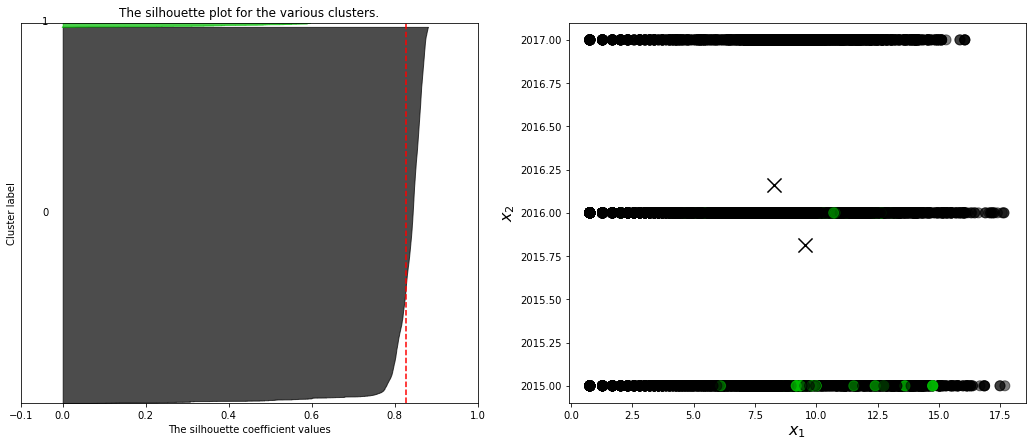

In [8]:
k = 2
kmeans = KMeans(n_clusters=k).fit(X)
plot_silhouette(X,k,kmeans.labels_,kmeans.cluster_centers_)

Se puede ver que no funciona muy bien, ya que obtenemos un inertia muy alto y casi todos los datos pertenecen al mismo grupo.

### Variable Objetivo: stays_nights

In [9]:
X = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).values
Y = data.stays_nights

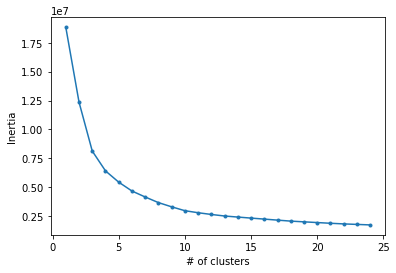

In [10]:
K = range(1,25)

inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(K,inertia,'.-')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

Aunque no queda un número muy claro, vamos a seleccionar K=10.

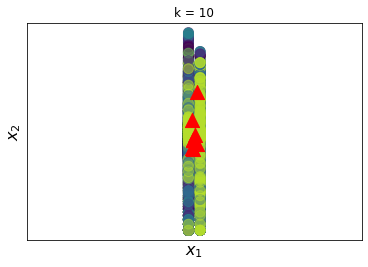

In [11]:
# build the clustering model
k = 10
kmeans = KMeans(n_clusters = k)
kmeans.fit(X)

# Centroids 
centroids = kmeans.cluster_centers_

# Labels
cluster_labels = kmeans.labels_

# do the plotting
plot_scatter(X,'k = ' + str(k), cluster_labels, centroids)
plt.show()

In [12]:
kmeans.predict(X)

array([3, 3, 3, ..., 8, 8, 8])

In [13]:
Y

0        7.0
1        2.0
2        2.0
3        4.0
4        2.0
        ... 
29995    4.0
29996    1.0
29997    2.0
29998    3.0
29999    2.0
Name: stays_nights, Length: 30000, dtype: float64

In [14]:
k = 10
kmeans = KMeans(n_clusters=k).fit(X)
kmeans.inertia_

2979605.9986141794

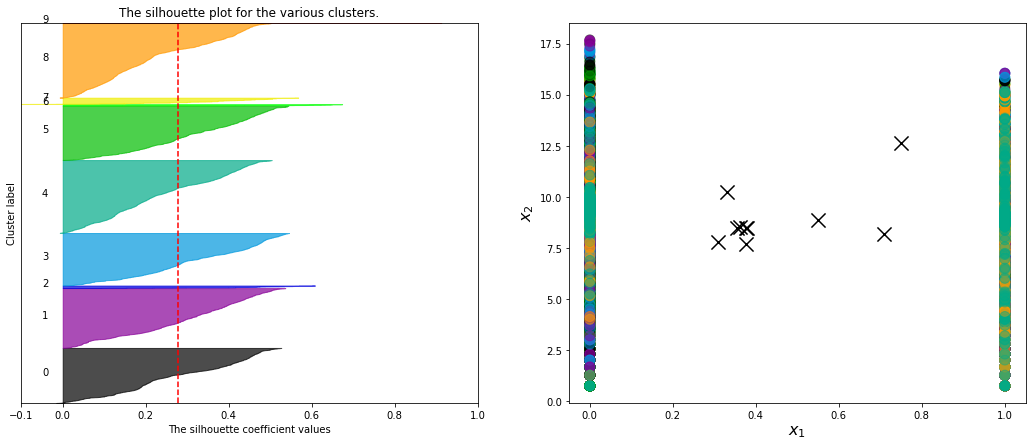

In [15]:
k = 10
kmeans = KMeans(n_clusters=k).fit(X)
plot_silhouette(X,k,kmeans.labels_,kmeans.cluster_centers_)

# Analisis Cluster variables seleccionadas

In [16]:
vars_s=['arrival_month','deposit_type_Non Refund','is_repeated_guest','reserverd/assigned','hotel_Resort Hotel']
Y = data.is_canceled
X = data[vars_s]

Realizaremos un analisis cluster de las variables 2 a 2 frente a la variable objetivo.
Para eloo primeramente realizaremos un scatter plot de las combinaciones.

ValueError: Unrecognized character a in format string

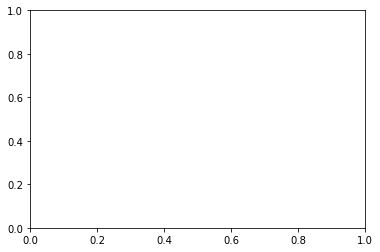

In [17]:
X.plot(x='arrival_month', y='deposit_type_Non Refund', style='scatter')